# **Connect to Drive and GPU**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 15 17:05:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# **Setup**

In [ ]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import tqdm
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

True

# **Data Preprocessing**



In [ ]:
dir = '/content/drive/MyDrive/datasets2D/ModelNet10_2D/'

In [ ]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
])
transforms_test = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(dir + "train", transforms_train)
test_dataset = datasets.ImageFolder(dir + "test", transforms_test)
validation_dataset = datasets.ImageFolder(dir + "validation", transforms_test)

batch_size = 15
num_workers = 8
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Validation dataset size:', len(validation_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)


Train dataset size: 64040
Test dataset size: 14020
Validation dataset size: 19920
Class names: ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']


# **Pretrained model**

In [ ]:
# Resnet34
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

# Add a fully-connected layer for classification
num_classes = len(class_names)
print('Number of classes for classification', num_classes)
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 106MB/s]


Number of features from pre-trained model 512
Number of classes for classification 10


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Training Phase**

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
from tqdm import tqdm

# Train model
train_loss=[]
train_accuracy=[]
val_loss=[]
val_accuracy=[]

num_epochs = 100   # Max number of epochs
start_time = time.time()

# Early stopping parameters
early_stop_threshold = 10 # Number of epochs to wait for improvement
early_stop_counter = 0
early_stop_best_acc = 0.0

# Start loop
for epoch in range(num_epochs):

    print("Epoch {} running".format(epoch))

    # Training Phase
    model.train()
    running_loss = 0.
    running_corrects = 0

    # Load a batch data of images
    for i, (inputs, labels) in enumerate(tqdm(train_dataloader, desc="Training")):

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()


    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.

    # Append result
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)

    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))


    # Validation Phase
    model.eval()
    with torch.no_grad():
        running_loss_val = 0.
        running_corrects_val = 0
        for i, (inputs, labels) in enumerate(tqdm(validation_dataloader, desc="Validation")):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculate accuracy for the validation set
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            running_corrects_val += torch.sum(preds == labels.data).item()

        epoch_loss_val = running_loss_val / len(validation_dataset)
        epoch_acc_val = (running_corrects_val / len(validation_dataset)) * 100.

        # Append result
        val_loss.append(epoch_loss_val)
        val_accuracy.append(epoch_acc_val)

        # Print progress
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss_val, epoch_acc_val, time.time()- start_time))

        # Early stopping check
        if epoch_acc_val > early_stop_best_acc:
            early_stop_best_acc = epoch_acc_val
            early_stop_counter = 0
            torch.save(model.state_dict(), "best_model.pt")  # Save the model
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_threshold:
            print("Early stopping after {} epochs of no improvement.".format(early_stop_threshold))
            num_epochs = epoch
            break  # End training loop

# Load the best model state
print('Best validation accuracy: {:.4f}'.format(early_stop_best_acc))
model.load_state_dict(torch.load("best_model.pt"))

Epoch 0 running


Training: 100%|██████████| 4270/4270 [43:30<00:00,  1.64it/s]


[Train #1] Loss: 0.0185 Acc: 90.7199% Time: 2611.0091s


Validation: 100%|██████████| 1328/1328 [15:01<00:00,  1.47it/s]


[Validation #1] Loss: 0.0119 Acc: 94.0462% Time: 3512.3898s
Epoch 1 running


Training: 100%|██████████| 4270/4270 [09:56<00:00,  7.16it/s]


[Train #2] Loss: 0.0095 Acc: 95.0250% Time: 4108.7456s


Validation: 100%|██████████| 1328/1328 [01:41<00:00, 13.12it/s]


[Validation #2] Loss: 0.0118 Acc: 94.2269% Time: 4210.0127s
Epoch 2 running


Training: 100%|██████████| 4270/4270 [10:02<00:00,  7.09it/s]


[Train #3] Loss: 0.0076 Acc: 96.0041% Time: 4812.5246s


Validation: 100%|██████████| 1328/1328 [01:48<00:00, 12.29it/s]


[Validation #3] Loss: 0.0118 Acc: 94.3725% Time: 4920.5539s
Epoch 3 running


Training: 100%|██████████| 4270/4270 [10:05<00:00,  7.05it/s]


[Train #4] Loss: 0.0063 Acc: 96.6162% Time: 5526.4205s


Validation: 100%|██████████| 1328/1328 [01:47<00:00, 12.30it/s]


[Validation #4] Loss: 0.0125 Acc: 93.7450% Time: 5634.3910s
Epoch 4 running


Training: 100%|██████████| 4270/4270 [10:12<00:00,  6.97it/s]


[Train #5] Loss: 0.0053 Acc: 97.2049% Time: 6247.1046s


Validation: 100%|██████████| 1328/1328 [01:42<00:00, 12.93it/s]


[Validation #5] Loss: 0.0099 Acc: 95.0753% Time: 6349.8181s
Epoch 5 running


Training: 100%|██████████| 4270/4270 [10:08<00:00,  7.02it/s]


[Train #6] Loss: 0.0049 Acc: 97.4157% Time: 6959.0299s


Validation: 100%|██████████| 1328/1328 [01:48<00:00, 12.23it/s]


[Validation #6] Loss: 0.0112 Acc: 94.8645% Time: 7067.6564s
Epoch 6 running


Training: 100%|██████████| 4270/4270 [10:08<00:00,  7.01it/s]


[Train #7] Loss: 0.0044 Acc: 97.7358% Time: 7676.3788s


Validation: 100%|██████████| 1328/1328 [01:45<00:00, 12.60it/s]


[Validation #7] Loss: 0.0142 Acc: 93.8655% Time: 7781.8007s
Epoch 7 running


Training: 100%|██████████| 4270/4270 [10:25<00:00,  6.83it/s]


[Train #8] Loss: 0.0041 Acc: 97.9263% Time: 8407.4266s


Validation: 100%|██████████| 1328/1328 [01:50<00:00, 12.03it/s]


[Validation #8] Loss: 0.0110 Acc: 95.2560% Time: 8517.8251s
Epoch 8 running


Training: 100%|██████████| 4270/4270 [09:59<00:00,  7.13it/s]


[Train #9] Loss: 0.0037 Acc: 98.0590% Time: 9117.3407s


Validation: 100%|██████████| 1328/1328 [01:43<00:00, 12.85it/s]


[Validation #9] Loss: 0.0184 Acc: 91.8474% Time: 9220.6624s
Epoch 9 running


Training: 100%|██████████| 4270/4270 [09:58<00:00,  7.13it/s]


[Train #10] Loss: 0.0034 Acc: 98.2261% Time: 9819.4307s


Validation: 100%|██████████| 1328/1328 [01:44<00:00, 12.68it/s]


[Validation #10] Loss: 0.0105 Acc: 95.5723% Time: 9924.1963s
Epoch 10 running


Training: 100%|██████████| 4270/4270 [10:00<00:00,  7.12it/s]


[Train #11] Loss: 0.0034 Acc: 98.1886% Time: 10524.6122s


Validation: 100%|██████████| 1328/1328 [01:42<00:00, 12.97it/s]


[Validation #11] Loss: 0.0089 Acc: 96.0291% Time: 10627.0245s
Epoch 11 running


Training: 100%|██████████| 4270/4270 [09:59<00:00,  7.12it/s]


[Train #12] Loss: 0.0031 Acc: 98.4229% Time: 11226.7159s


Validation: 100%|██████████| 1328/1328 [01:43<00:00, 12.86it/s]


[Validation #12] Loss: 0.0103 Acc: 95.3916% Time: 11329.9684s
Epoch 12 running


Training: 100%|██████████| 4270/4270 [09:59<00:00,  7.13it/s]


[Train #13] Loss: 0.0028 Acc: 98.5556% Time: 11929.0328s


Validation: 100%|██████████| 1328/1328 [01:42<00:00, 13.01it/s]


[Validation #13] Loss: 0.0105 Acc: 95.4267% Time: 12031.0976s
Epoch 13 running


Training: 100%|██████████| 4270/4270 [09:58<00:00,  7.13it/s]


[Train #14] Loss: 0.0028 Acc: 98.5696% Time: 12629.6873s


Validation: 100%|██████████| 1328/1328 [01:41<00:00, 13.12it/s]


[Validation #14] Loss: 0.0103 Acc: 95.5221% Time: 12730.9133s
Epoch 14 running


Training: 100%|██████████| 4270/4270 [09:57<00:00,  7.14it/s]


[Train #15] Loss: 0.0026 Acc: 98.6587% Time: 13328.7530s


Validation: 100%|██████████| 1328/1328 [01:41<00:00, 13.15it/s]


[Validation #15] Loss: 0.0123 Acc: 95.1807% Time: 13429.7887s
Epoch 15 running


Training: 100%|██████████| 4270/4270 [09:59<00:00,  7.13it/s]


[Train #16] Loss: 0.0025 Acc: 98.7211% Time: 14029.0897s


Validation: 100%|██████████| 1328/1328 [01:41<00:00, 13.03it/s]


[Validation #16] Loss: 0.0120 Acc: 94.6787% Time: 14131.0421s
Epoch 16 running


Training: 100%|██████████| 4270/4270 [09:59<00:00,  7.13it/s]


[Train #17] Loss: 0.0025 Acc: 98.7008% Time: 14730.2095s


Validation: 100%|██████████| 1328/1328 [01:43<00:00, 12.89it/s]


[Validation #17] Loss: 0.0108 Acc: 95.6275% Time: 14833.2550s
Epoch 17 running


Training: 100%|██████████| 4270/4270 [09:56<00:00,  7.16it/s]


[Train #18] Loss: 0.0024 Acc: 98.7664% Time: 15429.7339s


Validation: 100%|██████████| 1328/1328 [01:43<00:00, 12.89it/s]


[Validation #18] Loss: 0.0117 Acc: 95.1606% Time: 15532.7921s
Epoch 18 running


Training: 100%|██████████| 4270/4270 [09:58<00:00,  7.13it/s]


[Train #19] Loss: 0.0022 Acc: 98.8695% Time: 16131.7951s


Validation: 100%|██████████| 1328/1328 [01:46<00:00, 12.47it/s]


[Validation #19] Loss: 0.0119 Acc: 95.4418% Time: 16238.3007s
Epoch 19 running


Training: 100%|██████████| 4270/4270 [09:57<00:00,  7.15it/s]


[Train #20] Loss: 0.0022 Acc: 98.9163% Time: 16835.6804s


Validation: 100%|██████████| 1328/1328 [01:44<00:00, 12.74it/s]


[Validation #20] Loss: 0.0135 Acc: 94.7841% Time: 16939.9511s
Epoch 20 running


Training: 100%|██████████| 4270/4270 [09:57<00:00,  7.15it/s]


[Train #21] Loss: 0.0022 Acc: 98.8710% Time: 17537.3635s


Validation: 100%|██████████| 1328/1328 [01:41<00:00, 13.05it/s]


[Validation #21] Loss: 0.0111 Acc: 95.5673% Time: 17639.1353s
Early stopping after 10 epochs of no improvement.
Best validation accuracy: 96.0291


<All keys matched successfully>

# **Test Phase**

In [ ]:
# Test Phase
model.eval()
with torch.no_grad():
    running_loss_test = 0.
    running_corrects_test = 0
    for i, (inputs, labels) in enumerate(tqdm(test_dataloader, desc="Test")):

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Calculate accuracy for the test set
        loss = criterion(outputs, labels)
        running_loss_test += loss.item()
        running_corrects_test += torch.sum(preds == labels.data).item()

    loss_test = running_loss_test / len(test_dataset)
    acc_test = (running_corrects_test / len(test_dataset)) * 100.

    # Print result
    print('[Test] Loss: {:.4f} Acc: {:.4f}% '.format(loss_test, acc_test))


Test: 100%|██████████| 935/935 [10:19<00:00,  1.51it/s]

[Test] Loss: 0.0105 Acc: 95.3352% 


In [ ]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(num_epochs+1), train_accuracy,'-o')
plt.plot(np.arange(num_epochs+1), val_accuracy,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Accuracy over time')
plt.show()


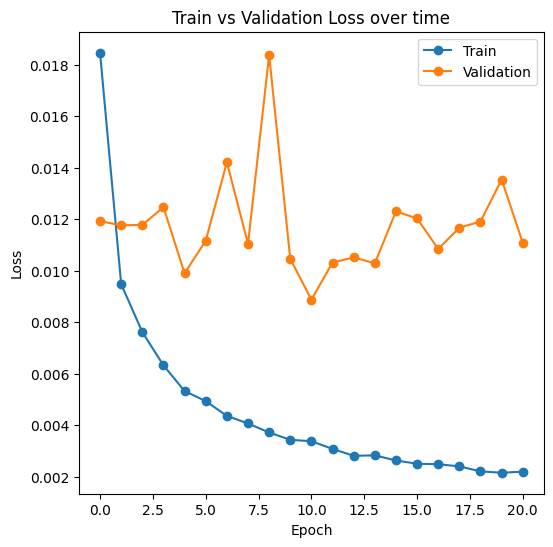

In [ ]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(num_epochs+1), train_loss,'-o')
plt.plot(np.arange(num_epochs+1), val_loss,'-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Loss over time')
plt.show()